In [20]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u
from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd
from mosdef_cassandra.utils.get_files import get_example_ff_path, get_example_mol2_path
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [25]:
def gcmcsim(molecule, atoms_ff,mus_adsorbate, cutoffmu, custom_args):
    for mu_adsorbate in mus_adsorbate:
        dirname = f'{molecule}-pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        else:
            pass
        
        with temporary_cd(dirname):
            species_list = [atoms_ff]
        
            if mu_adsorbate < cutoffmu:
                boxl = 5. # nm
            else:
                boxl = 2.5 # nm
        
            species_list = [atoms_ff]
        
            species_list = [atoms_ff]
            mols_to_add = [[16]]
        
            box_list = [mbuild.Box([boxl,boxl,boxl])]
            system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
            moveset = mc.MoveSet('gcmc', species_list)
        

            mc.run(
                system=system,
                moveset=moveset,
                run_type="equil",
                run_length=100000,
                temperature=450.0 * u.K,
                chemical_potentials = [mu_adsorbate],
                **custom_args
            )
        
def plot_loading(molecule, mus_adsorbate):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4), dpi=300)
    pressures = []
    for mu_adsorbate in mus_adsorbate:
        dirname = f'{molecule}-pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
        thermo = ThermoProps(dirname + "/gcmc.out.prp")
        pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    
    ax[0].plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))
    ax[0].set_xlabel("MC Step")
    ax[0].set_ylabel("Pressure (bar)")
    
    ax[1].plot(mus_adsorbate, pressures, 'go-')
    ax[1].set_xlabel("Chemical potential (kJ/mol)")
    ax[1].set_ylabel("Pressure [bar]")
    ax[1].set_yscale('log')
    plt.tight_layout()
    plt.show()
    
    slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())
    
    pressures = [
        50.0
    ] * u.bar
    
    mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
    for (mu, pressure) in zip(mus, pressures):
        print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")


    

## Formic Acid

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 1, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mbuild/formats/cassandramcf.py:134: UserWarning: Unable to infer LJ 1-4 scaling factor. Setting to 0.0
  warnings.warn(


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: 

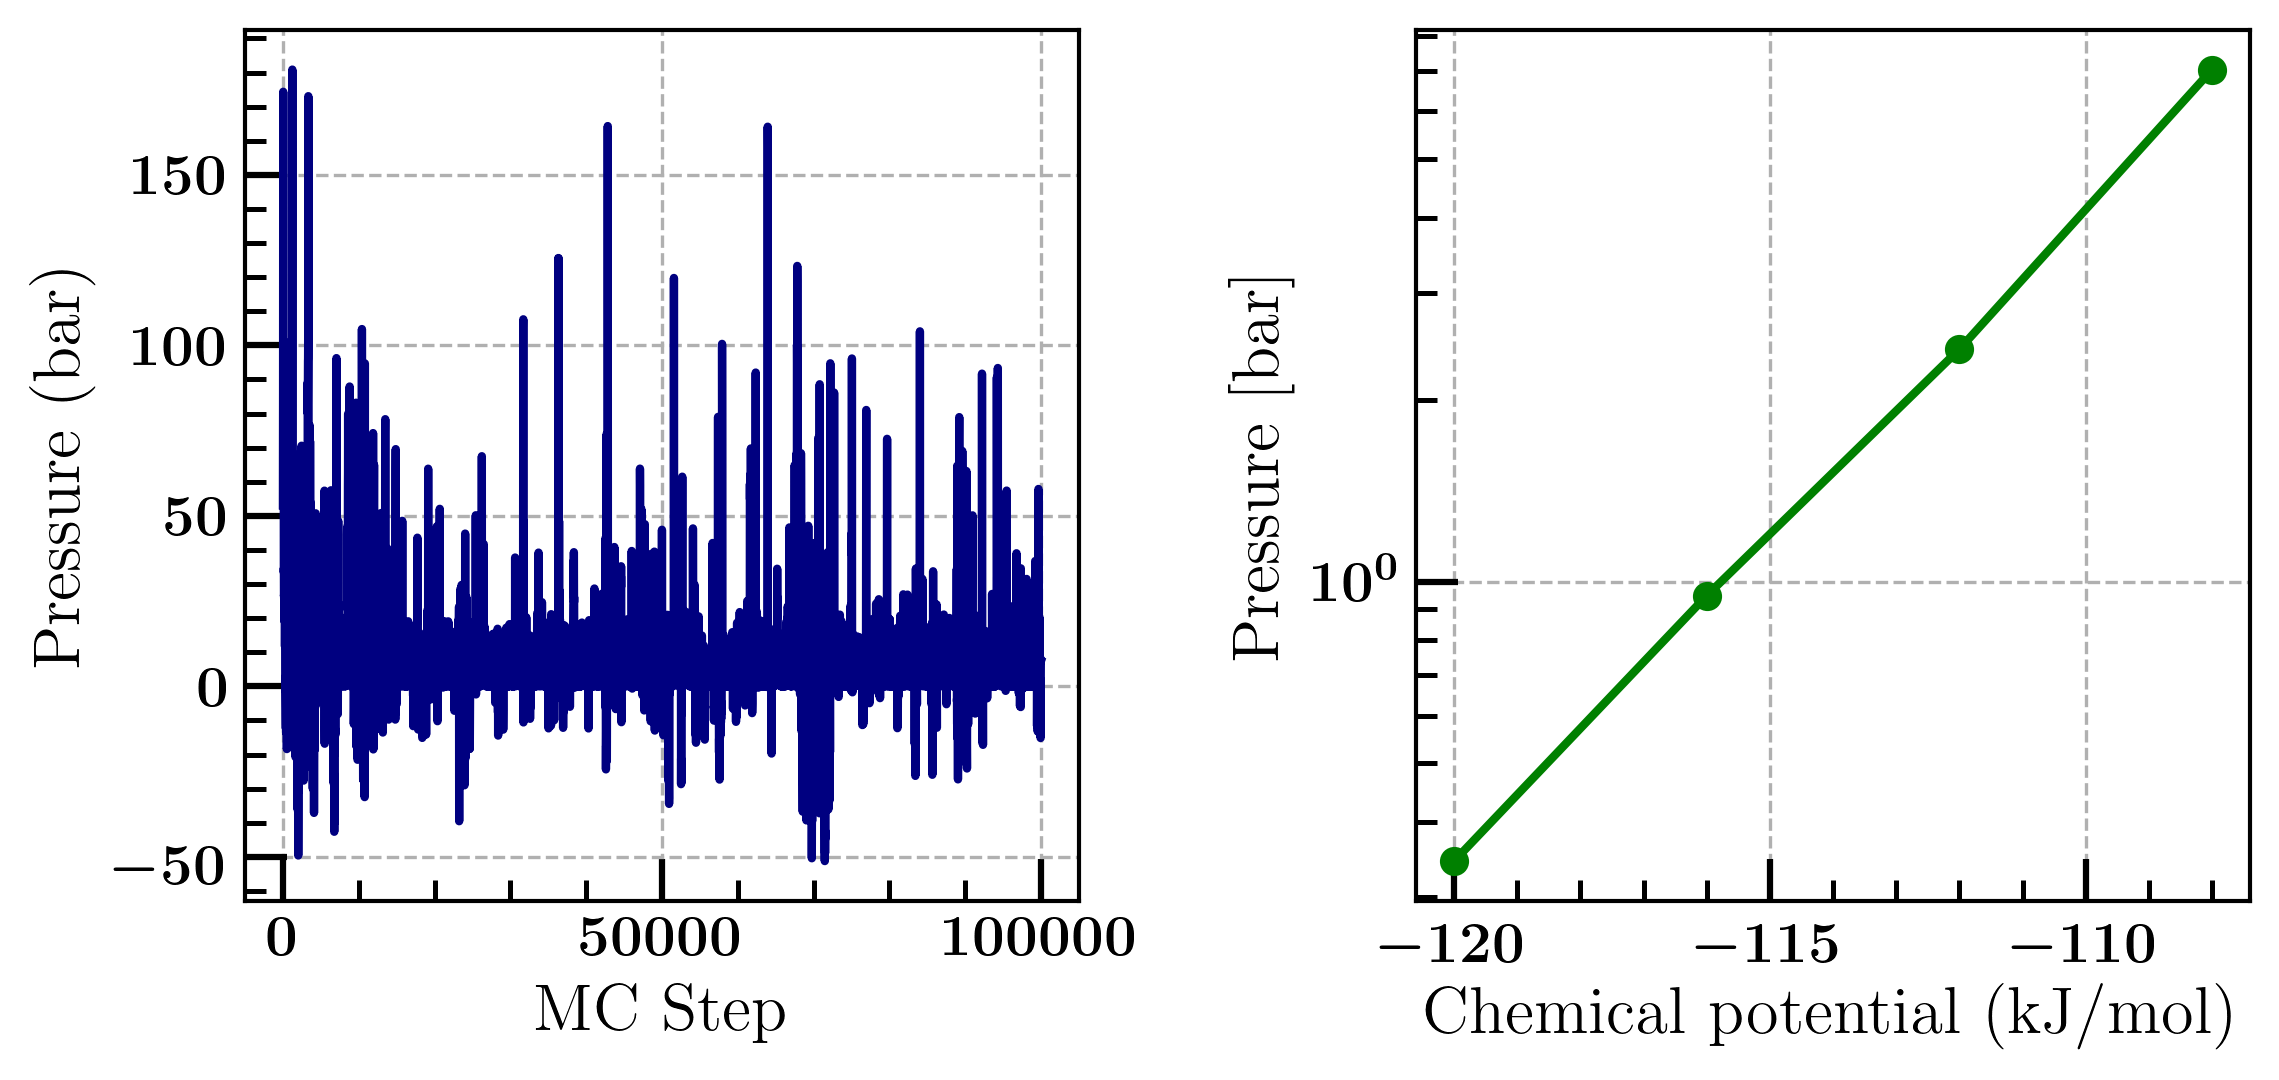

We will run at mu = -100.06 kJ/mol to simulate 50 bar


In [26]:
atoms = mbuild.load("O=CO", smiles=True)
ff = foyer.forcefields.load_OPLSAA()
atoms_ff = ff.apply(atoms)
custom_args = {
            "prop_freq" : 10,
            "max_molecules": [5000]
        }
mus_adsorbate = np.arange(-120, -105, 4) * u.kJ/u.mol
gcmcsim("formic_acid", atoms_ff, mus_adsorbate, -110, custom_args)
plot_loading("formic_acid", mus_adsorbate)

## Water

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:620: UserWarning: No force field version number found in force field XML file.
  warnings.warn(
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:632: UserWarning: No force field name found in force field XML file.
  warnings.warn(
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/foyer/forcefield.py:644: UserWarning: No combining rule found in force field XML file.
  warnings.warn(


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: 

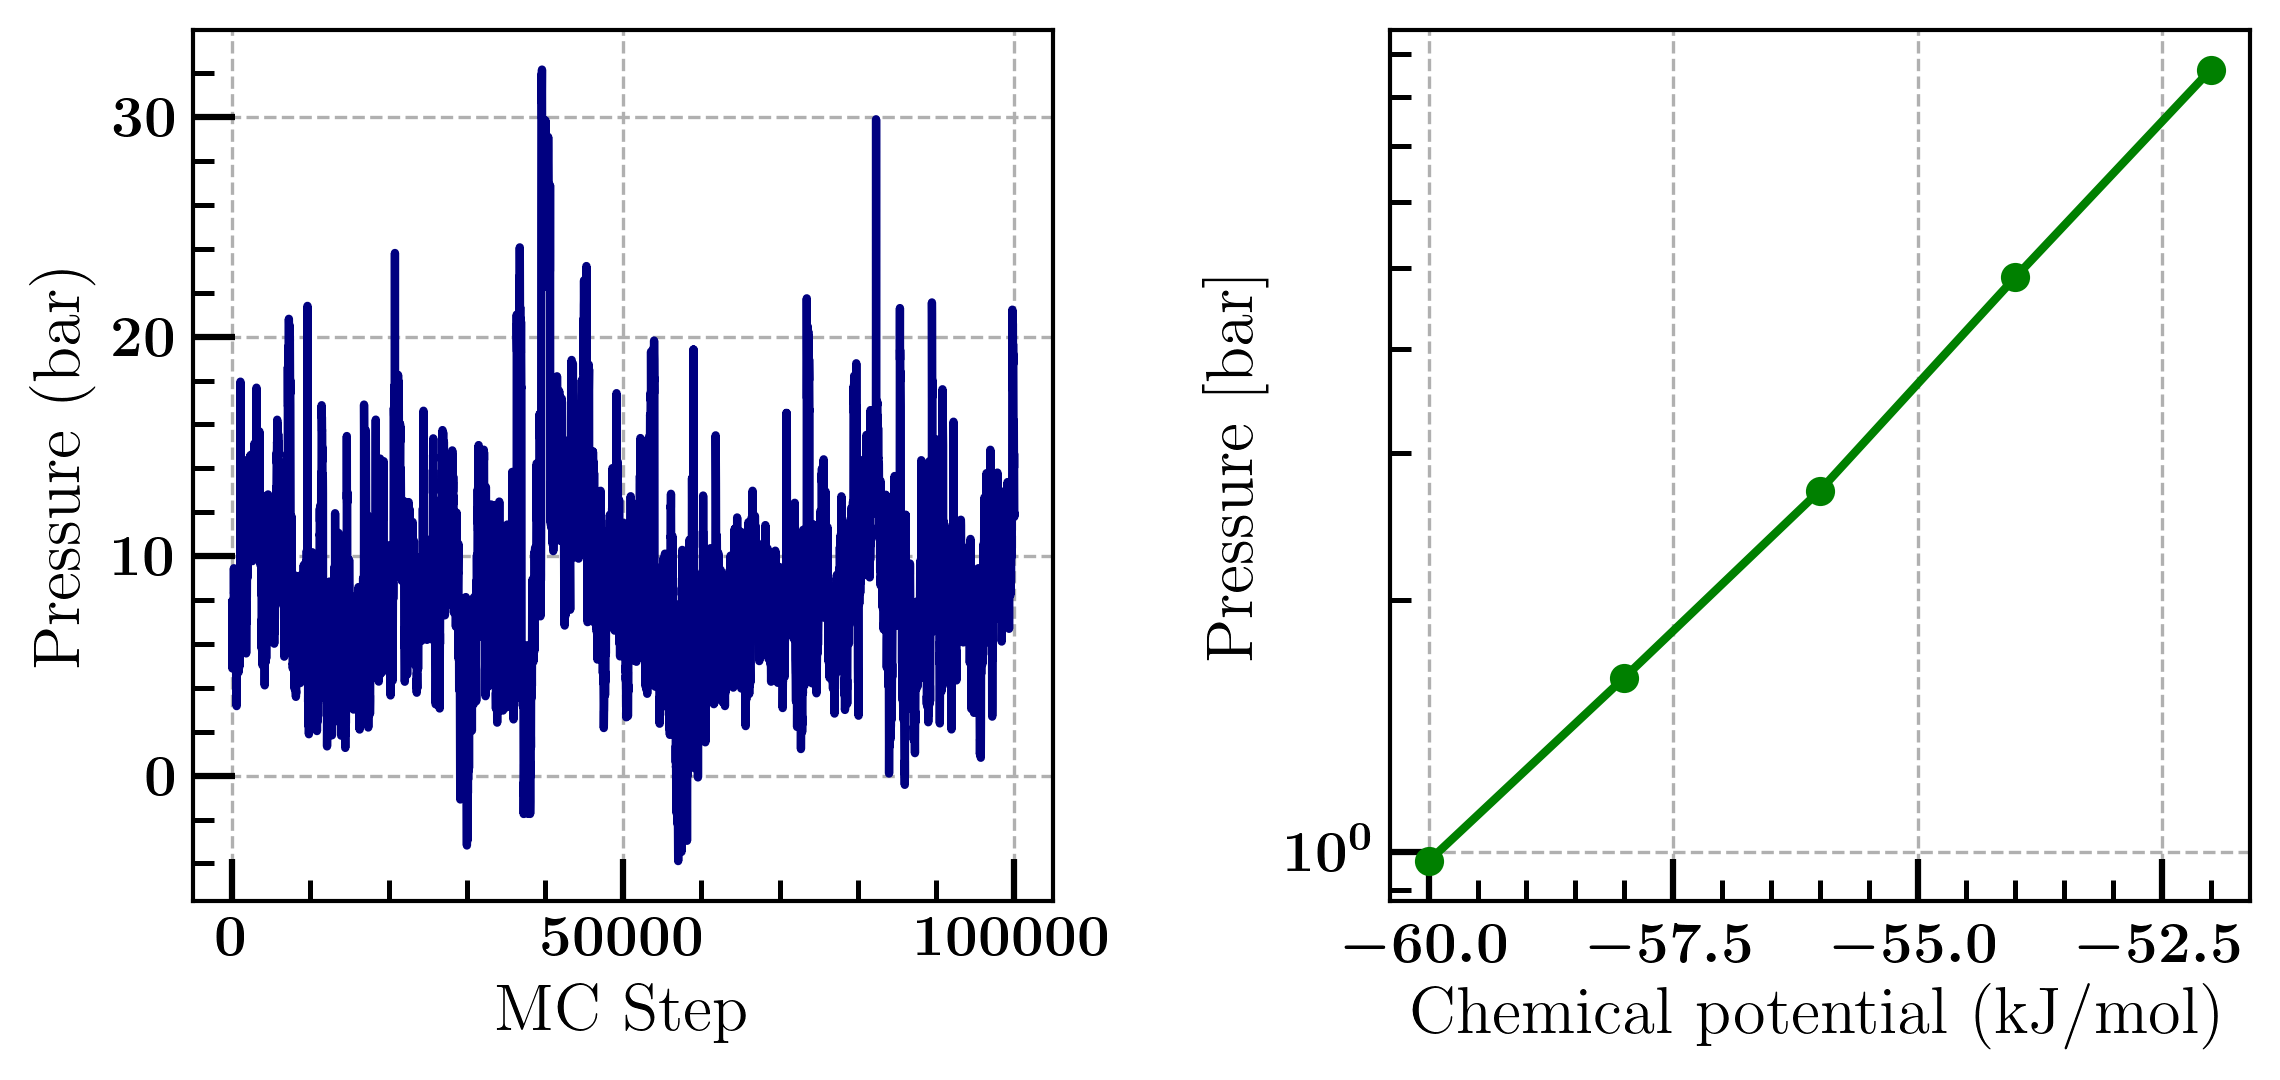

We will run at mu = -45.50 kJ/mol to simulate 50 bar


In [29]:
atoms = mbuild.load(get_example_mol2_path("spce"))
ff = foyer.Forcefield(get_example_ff_path("spce"))
atoms_ff = ff.apply(atoms)
custom_args = {"angle_style": ["fixed"],
               "prop_freq" : 10,
               "max_molecules": [5000]
              }

mus_adsorbate = np.arange(-60, -50, 2) * u.kJ/u.mol
gcmcsim("water", atoms_ff, mus_adsorbate, -45, custom_args)
plot_loading("water", mus_adsorbate)

## Methanol

In [ ]:
molecule = mbuild.load("CO", smiles=True)
molecule.energy_minimize(forcefield="GAFF")
ff = foyer.forcefields.load_OPLSAA()
atoms_ff = ff.apply(molecule)
custom_args = {"prop_freq" : 10,
               "max_molecules": [5000],
              "temperature": 450 * u.K}
mus_adsorbate = np.arange(-50, -40, 2) * u.kJ/u.mol
gcmcsim("methanol", atoms_ff, mus_adsorbate, -40, custom_args)
plot_loading("methanol", mus_adsorbate)

## Tetralin

In [ ]:
# Load water with SPC/E geometry from mol2 file
molecule = mbuild.load("c1ccc2c(c1)CCCC2", smiles=True)
molecule.energy_minimize(forcefield="GAFF")
ff = foyer.forcefields.load_OPLSAA()
atoms_ff = ff.apply(molecule)
custom_args = {"prop_freq" : 10,
               "max_molecules": [5000],
              "temperature": 450 * u.K}
mus_adsorbate = np.arange(-71, -69, 0.2) * u.kJ/u.mol
gcmcsim("methanol", atoms_ff, mus_adsorbate, -70, custom_args)
plot_loading("methanol", mus_adsorbate)